https://kesmarag.github.io/pde23/lectures/PartB.ipynb

https://kesmarag.github.io/pde23/lectures/xt.npy

https://kesmarag.github.io/pde23/lectures/prices.npy

### Dynamics of the stock price - Black-Scholes model

\\[\frac{dS_t}{S_t} = \mu dt + \sigma dW_t,\ t\in \mathbb T=[0,T], \ S_0 \ \text{is given}\\]

This is the stochastic differential equation that governs the dynamics of the stock price \\(S_t\\) over time. 
- Drift \\(\mu\\)
- Volatility \\(\sigma\\)
- Brownian motion \\(W_t\\).

### Solution of the SDE
Using the Ito Lemma we can obtain the solution of the SDE
\\[S_t = S_0 \exp\left(\left(\mu - \frac{\sigma^2}{2}\right)t + \sigma W_t\right)\\]

### European Call Option
A European call option is a type of financial contract that gives the holder (buyer) the right,
but not the obligation, to buy a specific stock at a pre-agreed price (strike price \\(K\\)) on a specified date (expiration date).

The payoff function of a European call option at expiration \\(T\\) is given by the positive part of difference between the stock price \\(S_T\\) and the strike price \\(K\\).
\\[\mathrm{Payoff}(S_T)=(S_T-K)^+\\]


### Principle of No-Arbitrage
In an efficient market, it is not possible to make risk-free profits.
- In the absence of arbitrage opportunities, the price of an option should be such that there are no possibilities for riskless profits.

### Price of the European Call Option
\\[V(s,t) = e^{-rt} \mathbb{E}_{\mathbb Q}\left[(S_T - K)^+| S_t = s\right]\\]

### Working with moneyness
The following equations provide a framework for valuing options based on moneyness and expected values, considering the relationship between the underlying asset's price and the strike price. 

\\[X_t = \frac{S_t}{K}\quad \text{(Moneyness)}\\]

\\[u(x,t) = e^{-rt}\mathbb{E}_{\mathbb Q}\left[(X_T - 1)^+| X_t = x\right]\\]

\\[V(s,t) = K\ u(s/K,t)\\]

### Solution

\\[u(x,t)= x  \Phi(d_1(x,t))-e^{-rt}\Phi (d_2(x,t))\\]
where
\\[d_1(x,t) = \frac{\ln(x)+ (r+\sigma^2/2)t}{\sigma\sqrt{t}}, \quad d_2(x,t) = \frac{\ln(x)+ (r-\sigma^2/2)t}{\sigma\sqrt{t}}\\]
and \\(\Phi(\cdot)\\) is the cumulative probability function of the  standard normal distribution.

### Creating a random path using the Black-Scholes model

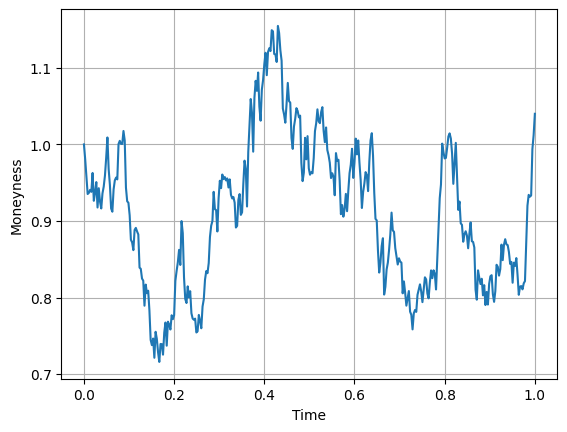

In [1]:
import numpy as np
import matplotlib.pyplot as plt

x = 1  # initial asset price
mu = 0.1 # drift
sigma = 0.5  # volatility
T = 1.0  # maturity time
N = 365  # number of time steps

dt = T / N
t = np.linspace(0, T, N+1)

z = np.random.standard_normal(N)

X = np.zeros(N+1)
X[0] = x

for i in range(N):
    X[i+1] = X[i] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z[i])

# Plot the simulation
plt.plot(t, X)
plt.xlabel('Time')
plt.ylabel('Moneyness')
plt.grid(True)


plt.show()

In [2]:
import torch
import torch.nn as nn
import numpy as np
from scipy.stats import norm

class ANN(nn.Module):
    
    def __init__(self, n_input, n_hidden, n_output):
        super(ANN, self).__init__()
        self.n_input = n_input
        self.n_output = n_output
        self.n_hidden = n_hidden

        # Parameters of the input layer
        self.wi = nn.Linear(n_input,n_hidden,bias=True)
        self.wi.weight = nn.Parameter(torch.randn((n_hidden,n_input)))
        
        # Parameters of the hidden layers
        self.wh0 = nn.Linear(n_hidden,n_hidden,bias=True)
        self.wh0.weight = nn.Parameter(torch.randn((n_hidden,n_hidden)))
        self.wh1 = nn.Linear(n_hidden,n_hidden,bias=True)
        self.wh1.weight = nn.Parameter(torch.randn((n_hidden,n_hidden)))
        
        # Parameters of the output layer
        self.wo = nn.Linear(n_hidden,n_output,bias=True)
        self.wo.weight = nn.Parameter(torch.randn((n_output,n_hidden)))
                
    def forward(self, xt):
        # Activation function
        afunc_tanh = torch.tanh
        # Input layer
        s0 = self.wi(xt)
        y0 = afunc_tanh(s0)
        # 1st hidden layer
        s1 = self.wh0(y0)
        y1 = afunc_tanh(s1)
        # 2nd hidden layer
        s2 = self.wh1(y1)
        y2 = afunc_tanh(s2)
        # Output layer
        s3 = self.wo(y2)
        return s3

    
class Supervised_Model():
    def __init__(self, ann):
        self.ann = ann
    
    def loss(self, xt, u_actual):
        u = self.ann.forward(xt).reshape(-1,1)
        u_actual = u_actual.reshape(-1,1)
        return torch.mean((u-u_actual)**2)
    
    def fit(self,xt,u_actual, iterations, lr=4e-3):
        
        # Optimization
        opt = torch.optim.Adam(self.ann.parameters(), lr)
        
        for it in range(iterations):
            opt.zero_grad()
            loss = self.loss(xt,u_actual)
            if it % 1000 == 0:
                eloss="{:e}".format(loss)
                print(it, eloss)
            loss.backward()
            opt.step()

In [3]:
ann = ANN(2,4,1)
model = Supervised_Model(ann)
xt = torch.Tensor(np.load('xt.npy'))
u_actual = torch.Tensor(np.load('prices.npy'))
total_params = sum(p.numel() for p in ann.parameters())
print('total parameters :', total_params)

total parameters : 57


In [4]:
model.fit(xt,u_actual,iterations=2**14)
# model2.fit(n=500,epoch=2**15)

0 1.109034e+00
1000 4.366531e-04
2000 1.364499e-04
3000 1.017290e-04
4000 8.683906e-05
5000 7.895868e-05
6000 7.405580e-05
7000 7.092618e-05
8000 2.141944e-04
9000 6.796445e-05
10000 6.705886e-05
11000 6.629821e-05
12000 6.827460e-05
13000 6.492587e-05
14000 6.428415e-05
15000 6.365058e-05
16000 6.302899e-05


In [5]:
x = torch.linspace(0,3,2**10).reshape(-1,1)
t = torch.ones(x.shape)
xt_sample = torch.cat([x,t],axis=1)
y = ann.forward(xt_sample)

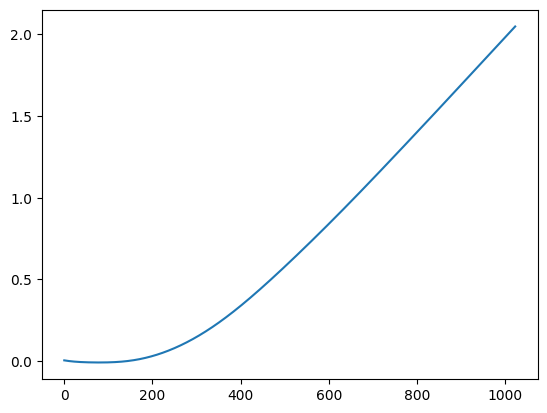

In [6]:
import matplotlib.pyplot as plt
plt.plot(y.detach().numpy())

In [7]:
import numpy as np
import math
from scipy.stats import norm

sigma = 0.5
r = 0.05
x = np.linspace(0, 3,2**10).reshape(-1,1)
t = 1
def black_scholes():
    ln = np.log(x)
    d1 = (ln+(r+0.5*sigma**2)*t)/(sigma*np.sqrt(t))
    d2 = (ln+(r-0.5*sigma**2)*t)/(sigma*np.sqrt(t))
    bs = x*norm.cdf(d1)-np.exp(-r*t)*norm.cdf(d2)
    return bs

In [8]:
price_formula = black_scholes()

/tmp/ipykernel_5166/605911854.py:10: RuntimeWarning: divide by zero encountered in log
  ln = np.log(x)


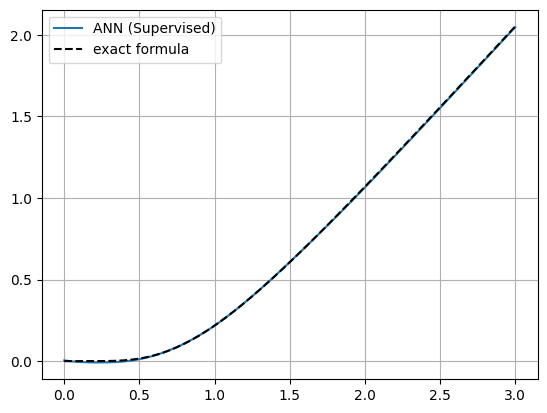

In [9]:
plt.plot(x,y.detach().numpy(),label='ANN (Supervised)')
plt.plot(x,price_formula,'--',c='black',label='exact formula')
plt.legend()
plt.grid()